In [76]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_validate

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
print(f"Rows in train.csv = {len(df_train)}")
print(f"Rows in test.csv = {len(df_test)}")
pd.set_option('display.max_colwidth', None)
df_train.head()

Rows in train.csv = 7613
Rows in test.csv = 3263


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [77]:
df_train_pos = df_train[df_train.target == 1]
df_train_neg = df_train[df_train.target == 0]
print(f"No. of positive training examples = {len(df_train_pos)}")
print(f"No. of negative training examples = {len(df_train_neg)}")
train_keywords_unique = df_train.keyword.unique()
print(f"No. of unique keywords = {len(train_keywords_unique)}")
df_train_notnull_keywords = df_train[~df_train.keyword.isnull()]
print(f"No of train examples with keyword not null = {len(df_train_notnull_keywords)}")
df_train_notnull_keywords.head()

No. of positive training examples = 3271
No. of negative training examples = 4342
No. of unique keywords = 222
No of train examples with keyword not null = 7552


,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0


In [78]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Preprocess the tweets 

In [79]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import string
import re

punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, ' ')
    return text

def process_tweet(df, text, keyword):
    lemmatizer = WordNetLemmatizer()    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)    
    processed_text = []
    stop = stopwords.words("english")
    for tweet, keyword in zip(df[text], df[keyword]):
        tweets_clean = []        
        # remove stock market tickers like $GE
        #tweet = tweet + " " + keyword
        tweet = re.sub(r'\$\w*', '', tweet)
        # remove old style retweet text "RT"
        tweet = re.sub(r'^RT[\s]+', '', tweet)
        # remove hyperlinks
        tweet = re.sub(r'http\S+', '', tweet)
        # remove hashtags
        # only removing the hash #, @, ... sign from the word
        tweet = re.sub(r'\.{3}|@|#', '', tweet)    
        tweet = clean_special_chars(tweet, punct)
        # remove junk characters which don't have an ascii code
        tweet = tweet.encode("ascii", "ignore").decode("utf-8", "ignore")
        # tokenize tweets        
        tweet_tokens = tokenizer.tokenize(tweet)
        for word in tweet_tokens:
            # remove stopwords and punctuation
            #if (word.isalpha() and len(word) > 2 #and word not in stop 
            #    and word not in string.punctuation):
                #stem_word = stemmer.stem(word)  # stemming word            
                #lem_word = lemmatizer.lemmatize(word)
                #tweets_clean.append(lem_word) 
                tweets_clean.append(word)
        processed_text.append(" ".join(tweets_clean))        
    df['processed_text'] = np.array(processed_text)

In [80]:
df_train["keyword"] = df_train["keyword"].fillna("no_keyword")
df_test["keyword"] = df_test["keyword"].fillna("no_keyword")
process_tweet(df_train, 'text', "keyword")
process_tweet(df_test, 'text', "keyword")
df_train["prcsd_tweet_len"] = df_train["processed_text"].apply(lambda row: len(row.split()))
df_test["prcsd_tweet_len"] = df_test["processed_text"].apply(lambda row: len(row.split()))

In [81]:
df_train["prcsd_tweet_len"].mean()

14.597136477078681

In [82]:
df_train.iloc[50:52, :]

,id,keyword,location,text,target,processed_text,prcsd_tweet_len
50,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k,1,deputies man shot before brighton home set ablaze,8
51,74,ablaze,India,Man wife get six years jail for setting ablaze niece\nhttp://t.co/eV1ahOUCZA,1,man wife get six years jail for setting ablaze niece,10


In [83]:

df_test.head()

,id,keyword,location,text,processed_text,prcsd_tweet_len
0,0,no_keyword,NaN,Just happened a terrible car crash,just happened a terrible car crash,6
1,2,no_keyword,NaN,"Heard about #earthquake is different cities, stay safe everyone.",heard about earthquake is different cities stay safe everyone,9
2,3,no_keyword,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",there is a forest fire at spot pond geese are fleeing across the street i cannot save them all,19
3,9,no_keyword,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,4
4,11,no_keyword,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan,8


## Let us try some deep learning techniques now

In [84]:
def get_word_embedding_dict(embedding_file_path):
    embedding_dict = {}
    with open(embedding_file_path, "r") as f:
        # https://stackoverflow.com/questions/8009882/how-to-read-a-large-file-line-by-line
        for line in f:
            values = line.split()
            word = values[0]
            word_vec = np.asarray(values[1:], "float32")
            embedding_dict[word] = word_vec
    return embedding_dict        

#glove_embedding_dict = get_word_embedding_dict("../../../glove.twitter.27B/glove.twitter.27B.200d.txt")

In [85]:
import torchtext

glove_emb = torchtext.vocab.GloVe(name="twitter.27B", dim=200)

In [86]:
# build tweets vocab from training data

from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(df):
    for index, row in df.iterrows():
        yield row["processed_text"].split()
    
tweet_vocab = build_vocab_from_iterator(yield_tokens(df_train), specials=["<unk>", "<pad>"])    

In [87]:
# For the problem specific vocab, get the embedding vectors from the pre-trained embedding
# for each word in vocab and return a matrix of shape vocab_size, embedding_dim. This matrix
# will be the pretrained embedding weight matrix which we will use to create the embedding layer
def get_vocab_pt_emb_matrix(text_vocab, emb):
    embedding_matrix = []
    for token in text_vocab.get_itos():
        embedding_matrix.append(emb[token])
    return torch.stack(embedding_matrix)

pt_emb_weights = get_vocab_pt_emb_matrix(tweet_vocab, glove_emb)
pt_emb_layer = nn.Embedding.from_pretrained(pt_emb_weights)

In [88]:
# [(index, token) for index, token in enumerate(glove_emb.itos) if token == "<unk>"]
#pt_emb_layer(torch.LongTensor([1]))

In [89]:
from torch.nn.utils.rnn import pad_sequence

df_train["vectorized_tweet"] = df_train["processed_text"].apply(
    lambda row:torch.LongTensor(tweet_vocab.lookup_indices(row.split()))
    )

#x_seq = df_train["vectorized_tweet"].values.tolist()
# the index for 'pad' token in tweet_vocab is 1.
#x_padded_seq = pad_sequence(x_seq, batch_first=True, padding_value=1)

In [90]:
from torch.utils.data import Dataset, DataLoader

class VectorizedTweetDataSet(Dataset):
    def __init__(self, tweet_vecs, labels):
        self.tweet_vecs = tweet_vecs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tweet_vec = self.tweet_vecs[idx]
        label = self.labels[idx]
        tweet_len = len(tweet_vec)
        return (tweet_vec, label)


In [91]:
# If the goal is to train with mini-batches, one needs to pad the sequences in each batch. 
# In other words, given a mini-batch of size N, if the length of the largest sequence is L, 
# one needs to pad every sequence with a length of smaller than L with zeros and make their 
# lengths equal to L. Moreover, it is important that the sequences in the batch are in the 
# descending order.
def pad_collate(batch):
    # Each element in the batch is a tuple (data, label)
    # sort the batch (based on tweet word count) in descending order
    sorted_batch = sorted(batch, key=lambda x:x[0].shape[0], reverse=True)
    sequences = [x[0] for x in sorted_batch]
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    # Also need to store the length of each sequence.This is later needed in order to unpad 
    # the sequences
    seq_len = torch.Tensor([len(x) for x in sequences])
    labels = torch.Tensor([x[1] for x in sorted_batch])
    return sequences_padded, seq_len, labels


In [93]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class DisasterModel(nn.Module):
    """The RNN model."""
    def __init__(self, vocab_size, num_layers, is_bidirect, emb_dim, hidden_dim, out_dim, 
                pt_emb_weights, emb_wt_update=False, drop_prob=0.5, **kwargs):
        super(DisasterModel, self).__init__(**kwargs)
        
        self.vocab_size = vocab_size
        self.num_layers = num_layers        
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim        
        self.output_dim = out_dim        
        self.is_bidirect = is_bidirect
        # Embedding layer
        self.emb_layer = nn.Embedding(self.vocab_size, emb_dim)
        # copy the vocab specific weights(emb vectors) from pretrained embeddings to model embedding layer
        self.emb_layer.weight.data.copy_(pt_emb_weights)    
        # whether to update the pretrained embedding layer weights during model training
        self.emb_layer.weight.requires_grad = emb_wt_update            
        # LSTM Layer        
        self.lstm_layer = nn.LSTM(
                        input_size=emb_dim, hidden_size=hidden_dim, batch_first=True, 
                        bidirectional=is_bidirect, num_layers=num_layers, dropout=drop_prob
                        )
        self.dropout = nn.Dropout(p = drop_prob)                        
        
        # If the RNN is bidirectional `num_directions` should be 2, else it should be 1.        
        if not is_bidirect:
            self.num_directions = 1
            # The linear layer is for making predictions 
            # input to linear output layer is of shape num_steps, batch_size, num_hiddens
            # and output is of shape num_steps, batch_size, vocab_size
            # Wya is of shape (vocab_size, num_hiddens), a_out is of shape (num_hiddens, 1)
            # yt_pred = np.dot(Wya, a_out) + b is of shape (vocab_size, 1)
            # replace 1 with m (batch_size) and add num_steps as the first dimension to have
            # vectorized form of the output
            self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        else:       
            self.num_directions = 2     
            self.linear = nn.Linear(self.hidden_dim * self.num_directions * 2, self.output_dim)
        # The activation layer which converts output to 0 or 1            
        self.act = nn.Sigmoid()            

    def forward(self, inputs, input_lengths, state):        
        # inputs is of shape batch_size, num_steps(sequence length which is the length of
        # longest text sequence). Each row of inputs is 1d LongTensor array of length 
        # num_steps containing word index. Using the embedding layer we want to convert
        # each word index to its corresponding word vector of dimension emb_dim
        batch_size = inputs.size(0)
        num_steps = inputs.size(1)        
        # embeds is of shape batch_size * num_steps * emb_dim and is the input to lstm layer
        embeds = self.emb_layer(inputs)        
        # pack_padded_sequence before feeding into LSTM. This is required so pytorch knows
        # which elements of the sequence are padded ones and ignore them in computation.
        # This step is done only after the embedding step
        embeds_pack = pack_padded_sequence(embeds, input_lengths, batch_first=True)
        # lstm_out is of shape batch_size * num_steps * hidden_size and contains the output
        # features (h_t) from the last layer of LSTM for each t
        # h_n is of shape num_layers * batch_size * hidden_size and contains the final hidden 
        # state for each element in the batch i.e. hidden state at t_end
        # same for c_n as h_n except that it is the final cell state
        lstm_out_pack, (h_n, c_n) = self.lstm_layer(embeds_pack)
        # unpack the output
        lstm_out, lstm_out_len = pad_packed_sequence(lstm_out_pack, batch_first=True)                
        if self.is_bidirect:
            # For a birection LSTM we need to concatenate the last output of each of the
            # forward (num_steps = 0, dim 2) and backward directions (num_steps = -1, dim 2)
            #print(f"lstm_out.shape = {lstm_out.shape}")
            lstm_out = torch.cat((lstm_out[:, 0, :], lstm_out[:, -1, :]), dim=1)
            #print(f"lstm_out.shape = {lstm_out.shape}")
        else:            
            # The output from lstm layer is the hidden state from last lstm layer with shape
            # of batch_size * hidden_dim. This can be extracted directly from h_n as below        
            lstm_out = h_n[-1, :, :]        
            # or we can extract it from lstm_out and lstm_out_len. lstm_out is of shape
            # batch_size * num_steps * hidden_dim. Now num_steps is the max sequence length
            # in the batch, but for items in batch for which sequence length < max sequence length
            # we need to take the element at lstm_out_len - 1 position in dimension 2 
            # as elements after it are padded and should be ignored. Thus instead of num_steps
            # if for each batch item we pick the element at (lstm_out_len - 1) index we get
            # lstm_out in the shape batch_size * hidden_dim
        
        # regularize lstm output by applying dropout
        out = self.dropout(lstm_out)        
        # The the output Y of fully connected rnn layer has the shape of 
        # (`num_steps` * `batch_size`, `num_hiddens`). This Y is then fed as input to the 
        # output fully connected linear layer which produces the prediction in the output shape of 
        # (`num_steps` * `batch_size`, `output_dim`).        
        output = self.linear(out)        
        # apply sigmoid activation to convert output to probability 
        output = self.act(output)
        return output, (h_n, c_n)

    def init_state(self, device, batch_size=1):
        """ Initialize the hidden state i.e. initialize all the neurons in all the hidden layers 
        to zero"""
        if not isinstance(self.lstm_layer, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return torch.zeros((self.num_directions * self.num_layers,
                                batch_size, self.hidden_dim), device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states (h0, c0). h0 = initial
            # hidden state for each element in the batch, c0 = initial cell state
            # for each element in the batch
            return (torch.zeros((self.num_directions * self.num_layers,
                                 batch_size, self.hidden_dim), device=device),
                    torch.zeros((self.num_directions * self.num_layers,
                                 batch_size, self.hidden_dim), device=device))

In [94]:
class ModelExecutionEngine:
    def __init__(self, model, optimizer, device, batch_size, grad_clip):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.batch_size = batch_size
        self.grad_clip = grad_clip

    @staticmethod
    def loss_fn(outputs, targets):
        return nn.BCELoss()(outputs, targets)

    # metric to measure model performance
    def accuracy(self, outputs, targets):
        # y_pred is in the range 0 to 1. Convert it to 0 or 1 by rounding
        outputs_round = torch.round(outputs.squeeze())
        correct = (outputs_round == targets.squeeze()).float()
        acc = correct.sum() / len(correct)
        return acc

    def train_epoch(self, data_loader, init_hidden):
        self.model.train()
        loss_epoch = []
        acc_epoch = [] 
        for inputs, input_lengths, labels in data_loader:
            # create a new hidden state instance for each minibatch to avoid long gradient chains
            # involving all previous minibatches of an epoch
            h = tuple([e.data for e in init_hidden])
            inputs = inputs.to(self.device)
            input_lengths = input_lengths.to(self.device)
            labels = labels.to(self.device)
            if inputs.shape[0] != self.batch_size:
                continue        
            # forward pass on one mini batch
            output, hidden = self.model(inputs, input_lengths, h)        
            # compute the loss
            loss = self.loss_fn(output.squeeze(), labels.float())
            epoch_acc = self.accuracy(output, labels)        
            acc_epoch.append(epoch_acc.item())
            loss_epoch.append(loss.item())
            # zero out the model param (W and b) gradients before running backprop on this batch 
            # otherwise gradients will keep on aggregating from one batch to next
            self.optimizer.zero_grad()
            # run backprop to calculate param gradients (dW and db)
            loss.backward()
            # clip the param gradients if they exceed threshold
            nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
            # update the parameters (W and b)
            self.optimizer.step()            
        return np.mean(loss_epoch), np.mean(acc_epoch)  

    def evaluate_epoch(self, data_loader, init_hidden):
        self.model.eval()
        loss_epoch = []
        acc_epoch = [] 
        for inputs, input_lengths, labels in data_loader:
            h = tuple([e.data for e in init_hidden])
            inputs = inputs.to(self.device)
            input_lengths = input_lengths.to(self.device)
            labels = labels.to(self.device)
            if inputs.shape[0] != self.batch_size:
                continue                    
            output, hidden = self.model(inputs, input_lengths, h)        
            loss = self.loss_fn(output.squeeze(), labels.float())
            epoch_acc = self.accuracy(output, labels)        
            acc_epoch.append(epoch_acc.item())
            loss_epoch.append(loss.item())            
        return np.mean(loss_epoch), np.mean(acc_epoch)  

In [104]:
# model constants
VOCAB_SIZE = len(tweet_vocab)
EMB_DIM = 200    
OUT_DIM = 1    
BATCH_SIZE = 128
GRAD_CLIP = 5
NUM_EPOCHS = 20 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
# model hyperparameters
model_params = {
    "hidden_dim": 141, 
    "num_layers": 2, 
    "is_bidirectional": False, 
    "drop_out": 0.4258,
    "learning_rate": 0.000366
    }

In [96]:
def get_exec_time(exec_time_secs):
    if exec_time_secs < 60:
        return f"{round(exec_time_secs, 2)} seconds"
    exec_time_rem_sec = exec_time_secs % 60
    exec_time_min = int((exec_time_secs - exec_time_rem_sec) / 60)
    return f"{exec_time_min} min {round(exec_time_rem_sec, 2)} seconds"

def print_epoch_stats(epoch, train_run_time, train_loss, 
                     train_acc, val_run_time, val_loss, val_acc):
    print(f"=======================================================")
    print(f"Epoch {epoch} :")
    print(f"Execution time on training set = {train_run_time} ")
    print(f"Training loss = {round(train_loss, 4)}, training accuracy = {round(train_acc, 4)}")
    print(f"Execution time on validation set = {val_run_time} ")
    print(f"Validation loss = {round(val_loss, 4)}, validation accuracy = {round(val_acc, 4)}")        
    print(f"=======================================================")        

In [105]:
def run_training(train_dl, val_dl, params, save_model=False):
    val_loss_min = np.Inf   
    model = DisasterModel(
                vocab_size = VOCAB_SIZE, 
                emb_dim = EMB_DIM, 
                out_dim = OUT_DIM, 
                pt_emb_weights = pt_emb_weights,
                num_layers = params["num_layers"], 
                is_bidirect = False,  
                hidden_dim = params["hidden_dim"], 
                drop_prob = params["drop_out"]                
                ).to(DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    init_hidden = model.init_state(device = DEVICE, batch_size = BATCH_SIZE)        
    mee = ModelExecutionEngine(
            model=model, 
            optimizer=optimizer, 
            device=DEVICE, 
            batch_size=BATCH_SIZE,
            grad_clip=GRAD_CLIP
            )
    # number of epoch iterations with the validation loss not decreasing 
    # before training process is terminated before completed the total number of epochs             
    early_stopping_iter = 10            
    early_stopping_counter = 0     
    model_exec_stats = {
        "all_train_loss": [],
        "all_train_acc": [],
        "all_val_loss": [],
        "all_val_acc": []
        }       
    for epoch in range(NUM_EPOCHS):
        train_start_time = time.time()
        train_loss, train_acc = mee.train_epoch(train_dl, init_hidden)
        model_exec_stats["all_train_loss"].append(train_loss)
        model_exec_stats["all_train_acc"].append(train_acc)
        train_end_time = time.time()    
        train_run_time = get_exec_time(train_end_time - train_start_time)
        val_start_time = time.time()
        val_loss, val_acc = mee.evaluate_epoch(val_dl, init_hidden)
        model_exec_stats["all_val_loss"].append(val_loss)
        model_exec_stats["all_val_acc"].append(val_acc)
        val_end_time = time.time()
        val_run_time = get_exec_time(val_end_time - val_start_time)
        print_epoch_stats(epoch, train_run_time, train_loss, train_acc,
                            val_run_time, val_loss, val_acc)  
        if val_loss < val_loss_min:                        
            if save_model:
                print(f"Validation loss decreased from " +
                f"{round(val_loss_min, 6)} --> {round(val_loss, 6)}. Saving model...")                
                torch.save(model, "best_model.pt")                
            val_loss_min = val_loss
        else:
            early_stopping_counter += 1
        if early_stopping_counter > early_stopping_iter:
            break
    return val_loss_min, model_exec_stats

In [108]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

tweet_ds = VectorizedTweetDataSet(df_train["vectorized_tweet"].values, df_train["target"].values)
# split the tweet_ds into train and validation datasets with 80:20 ratio
train_idx, val_idx = train_test_split(list(range(len(tweet_ds))), test_size=0.2, random_state=42)
train_ds = Subset(tweet_ds, train_idx)
val_ds = Subset(tweet_ds, val_idx)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)

val_loss_min, model_exec_stats = run_training(train_dl, val_dl, params=model_params, save_model=True)

Epoch 0 :
Execution time on training set = 17.16 seconds 
Training loss = 0.632, training accuracy = 0.6368
Execution time on validation set = 1.02 seconds 
Validation loss = 0.5389, validation accuracy = 0.7273
Validation loss decreased from inf --> 0.53889. Saving model...
Epoch 1 :
Execution time on training set = 18.54 seconds 
Training loss = 0.4867, training accuracy = 0.7814
Execution time on validation set = 0.94 seconds 
Validation loss = 0.4505, validation accuracy = 0.804
Validation loss decreased from 0.53889 --> 0.450504. Saving model...
Epoch 2 :
Execution time on training set = 17.32 seconds 
Training loss = 0.4478, training accuracy = 0.8044
Execution time on validation set = 1.06 seconds 
Validation loss = 0.4434, validation accuracy = 0.8146
Validation loss decreased from 0.450504 --> 0.443379. Saving model...
Epoch 3 :
Execution time on training set = 15.66 seconds 
Training loss = 0.4289, training accuracy = 0.811
Execution time on validation set = 0.78 seconds 
Val

In [109]:
all_val_loss = model_exec_stats["all_val_loss"]
all_val_acc = model_exec_stats["all_val_acc"]
min_loss_index = np.argmin(all_val_loss)
print(f"Min val loss = {all_val_loss[min_loss_index]}, corresponding val accuracy = {all_val_acc[min_loss_index]}")

Min val loss = 0.4237306443127719, corresponding val accuracy = 0.8267045454545454


In [110]:
import matplotlib.pyplot as plt

def plot_train_val_metrics(ax, train_metric, val_metric, metric_name):
    ax.plot(train_metric, label = f"training {metric_name}")
    ax.plot(val_metric, label = f"validation {metric_name}")
    ax.set_xlabel("epochs")
    ax.set_ylabel(metric_name)
    ax.set_title(f"{metric_name} vs epochs")
    ax.legend()
    ax.grid()

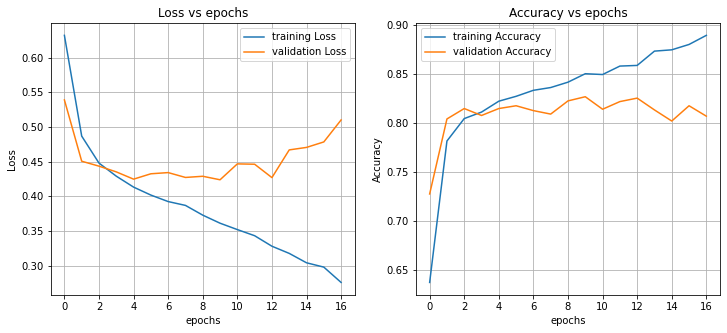

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_train_val_metrics(ax1, model_exec_stats["all_train_loss"], model_exec_stats["all_val_loss"], "Loss")
plot_train_val_metrics(ax2, model_exec_stats["all_train_acc"], model_exec_stats["all_val_acc"], "Accuracy")

In [112]:
best_model = torch.load("best_model.pt")
print(best_model)
tweet_vocab.set_default_index(0)
df_test["vectorized_tweet"] = df_test["processed_text"].apply(
    lambda row:torch.LongTensor(tweet_vocab.lookup_indices(row.split()))
    )

# Do prediction with best performing model on the test set
def predict(df_test):
    test_output = []
    for index, row in df_test.iterrows():    
        vec_tweet = row["vectorized_tweet"]
        if len(vec_tweet) == 0:
            test_output.append(0)
            continue
        vec_tweet_len = torch.IntTensor([len(vec_tweet)])
        vec_tweet = vec_tweet.view(1, -1)    
        #print(vec_tweet, vec_tweet_len)
        output, (h_n,c_n) = best_model(vec_tweet, vec_tweet_len, state=None)
        #print(output)
        test_output.append(round(output.item()))    
    return test_output        

test_output = predict(df_test)
print(len(test_output))

df_submission = pd.read_csv('./data/submission.csv')
df_submission['target']= test_output
df_submission.to_csv('my_submission.csv',index=False)

DisasterModel(
  (emb_layer): Embedding(17120, 200)
  (lstm_layer): LSTM(200, 141, num_layers=2, batch_first=True, dropout=0.4258)
  (dropout): Dropout(p=0.4258, inplace=False)
  (linear): Linear(in_features=141, out_features=1, bias=True)
  (act): Sigmoid()
)
3263


In [ ]:
# Wrapper method to run training for hyperparameter optimization as in this case the function 
# to be optimized needs to return one float value
def hyperparam_tune_run(train_dl, val_dl, params):
    min_val_loss, _ = run_training(train_dl, val_dl, params)
    return min_val_loss

In [75]:
import optuna
import time

#[I 2021-10-21 12:06:44,242] Trial 15 finished with value: 0.4088201341421708 and parameters: 
# {'hidden_dim': 141, 'drop_out': 0.4257934114073623, 'learning_rate': 0.0003660548388149779, 
# 'num_layers': 2}. Best is trial 15 with value: 0.4088201341421708.

def objective(trial):
    params = {
        "hidden_dim": trial.suggest_int("hidden_dim", 32, 512),
        "drop_out": trial.suggest_uniform("drop_out", 0.2, 0.7),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-3),
        #"is_bidirectional": trial.suggest_int("is_bidirectional", 0, 1),
        "num_layers": trial.suggest_int("num_layers", 1, 2)
    }
    loss = hyperparam_tune_run(train_dl, val_dl, params)
    trial_num = trial.number
    print(f"loss at end of trial {trial_num} execution = {loss}")
    print(f"trial {trial_num} params = {trial.params}")
    return loss

study = optuna.create_study(direction="minimize", study_name="DisasterModelTuning")    
study.optimize(objective, n_trials=20)
print("Best trial:")
print(study.best_params)

#Best trial:
#{'hidden_dim': 141, 'drop_out': 0.4257934114073623, 'learning_rate': 0.0003660548388149779, 'num_layers': 2}

[I 2021-10-21 11:25:31,963] A new study created in memory with name: DisasterModelTuning
D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28595202687455995 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 :
Execution time on training set = 25.65 seconds 
Training loss = 0.6851, training accuracy = 0.5663
Execution time on validation set = 0.99 seconds 
Validation loss = 0.6766, validation accuracy = 0.5842
Epoch 1 :
Execution time on training set = 27.08 seconds 
Training loss = 0.6715, training accuracy = 0.5859
Execution time on validation set = 0.86 seconds 
Validation loss = 0.6635, validation accuracy = 0.5883
Epoch 2 :
Execution time on training set = 23.92 seconds 
Training loss = 0.6548, training accuracy = 0.6161
Execution time on validation set = 0.87 seconds 
Validation loss = 0.6413, validation accuracy = 0.6318
Epoch 3 :
Execution time on training set = 24.8 seconds 
Training loss = 0.6172, training accuracy = 0.6862
Execution time on validation set = 0.86 seconds 
Validation loss = 0.5894, validation accuracy = 0.7588
Epoch 4 :
Execution time on training set = 25.01 seconds 
Training loss = 0.5602, training accuracy = 0.7518
Execution time on validation set = 0.89 

[I 2021-10-21 11:29:49,965] Trial 0 finished with value: 0.46606087814206665 and parameters: {'hidden_dim': 450, 'drop_out': 0.28595202687455995, 'learning_rate': 1.180072487915846e-05, 'num_layers': 1}. Best is trial 0 with value: 0.46606087814206665.


Epoch 9 :
Execution time on training set = 25.44 seconds 
Training loss = 0.4704, training accuracy = 0.7961
Execution time on validation set = 0.88 seconds 
Validation loss = 0.4661, validation accuracy = 0.8037
loss at end of trial 0 execution = 0.46606087814206665
trial 0 params = {'hidden_dim': 450, 'drop_out': 0.28595202687455995, 'learning_rate': 1.180072487915846e-05, 'num_layers': 1}


D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22901101470238705 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 :
Execution time on training set = 7.24 seconds 
Training loss = 0.5821, training accuracy = 0.6952
Execution time on validation set = 0.39 seconds 
Validation loss = 0.4663, validation accuracy = 0.7996
Epoch 1 :
Execution time on training set = 8.08 seconds 
Training loss = 0.4543, training accuracy = 0.8023
Execution time on validation set = 0.36 seconds 
Validation loss = 0.4382, validation accuracy = 0.8071
Epoch 2 :
Execution time on training set = 8.13 seconds 
Training loss = 0.4267, training accuracy = 0.8133
Execution time on validation set = 0.38 seconds 
Validation loss = 0.431, validation accuracy = 0.8118
Epoch 3 :
Execution time on training set = 7.96 seconds 
Training loss = 0.4144, training accuracy = 0.8189
Execution time on validation set = 0.37 seconds 
Validation loss = 0.4319, validation accuracy = 0.8084
Epoch 4 :
Execution time on training set = 8.13 seconds 
Training loss = 0.4033, training accuracy = 0.8232
Execution time on validation set = 0.38 secon

[I 2021-10-21 11:31:14,843] Trial 1 finished with value: 0.4264820166256117 and parameters: {'hidden_dim': 176, 'drop_out': 0.22901101470238705, 'learning_rate': 0.0002858590842902684, 'num_layers': 1}. Best is trial 1 with value: 0.4264820166256117.


Epoch 9 :
Execution time on training set = 7.97 seconds 
Training loss = 0.3599, training accuracy = 0.8424
Execution time on validation set = 0.37 seconds 
Validation loss = 0.4265, validation accuracy = 0.8173
loss at end of trial 1 execution = 0.4264820166256117
trial 1 params = {'hidden_dim': 176, 'drop_out': 0.22901101470238705, 'learning_rate': 0.0002858590842902684, 'num_layers': 1}


D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6714768410303671 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 :
Execution time on training set = 16.58 seconds 
Training loss = 0.5197, training accuracy = 0.7498
Execution time on validation set = 0.62 seconds 
Validation loss = 0.4454, validation accuracy = 0.8037
Epoch 1 :
Execution time on training set = 16.07 seconds 
Training loss = 0.44, training accuracy = 0.8105
Execution time on validation set = 0.63 seconds 
Validation loss = 0.4457, validation accuracy = 0.8064
Epoch 2 :
Execution time on training set = 16.17 seconds 
Training loss = 0.4176, training accuracy = 0.8188
Execution time on validation set = 0.63 seconds 
Validation loss = 0.4307, validation accuracy = 0.8098
Epoch 3 :
Execution time on training set = 16.08 seconds 
Training loss = 0.4034, training accuracy = 0.8212
Execution time on validation set = 0.65 seconds 
Validation loss = 0.4316, validation accuracy = 0.8105
Epoch 4 :
Execution time on training set = 14.17 seconds 
Training loss = 0.3897, training accuracy = 0.8308
Execution time on validation set = 0.64 s

[I 2021-10-21 11:33:07,416] Trial 2 finished with value: 0.4306647647982058 and parameters: {'hidden_dim': 311, 'drop_out': 0.6714768410303671, 'learning_rate': 0.0006091971942534142, 'num_layers': 1}. Best is trial 1 with value: 0.4264820166256117.


Epoch 6 :
Execution time on training set = 14.62 seconds 
Training loss = 0.3579, training accuracy = 0.8467
Execution time on validation set = 0.56 seconds 
Validation loss = 0.4367, validation accuracy = 0.8166
loss at end of trial 2 execution = 0.4306647647982058
trial 2 params = {'hidden_dim': 311, 'drop_out': 0.6714768410303671, 'learning_rate': 0.0006091971942534142, 'num_layers': 1}


D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.36748850411197787 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 :
Execution time on training set = 10.77 seconds 
Training loss = 0.6265, training accuracy = 0.6554
Execution time on validation set = 0.49 seconds 
Validation loss = 0.5326, validation accuracy = 0.7466
Epoch 1 :
Execution time on training set = 11.22 seconds 
Training loss = 0.4852, training accuracy = 0.7867
Execution time on validation set = 0.45 seconds 
Validation loss = 0.4501, validation accuracy = 0.8098
Epoch 2 :
Execution time on training set = 11.51 seconds 
Training loss = 0.4442, training accuracy = 0.8087
Execution time on validation set = 0.49 seconds 
Validation loss = 0.4411, validation accuracy = 0.8071
Epoch 3 :
Execution time on training set = 10.13 seconds 
Training loss = 0.4303, training accuracy = 0.8107
Execution time on validation set = 0.49 seconds 
Validation loss = 0.426, validation accuracy = 0.8159
Epoch 4 :
Execution time on training set = 10.07 seconds 
Training loss = 0.4178, training accuracy = 0.8163
Execution time on validation set = 0.46 

[I 2021-10-21 11:34:56,604] Trial 3 finished with value: 0.4220047346923662 and parameters: {'hidden_dim': 244, 'drop_out': 0.36748850411197787, 'learning_rate': 0.00013161988541106158, 'num_layers': 1}. Best is trial 3 with value: 0.4220047346923662.


Epoch 9 :
Execution time on training set = 10.13 seconds 
Training loss = 0.3847, training accuracy = 0.8368
Execution time on validation set = 0.46 seconds 
Validation loss = 0.429, validation accuracy = 0.8152
loss at end of trial 3 execution = 0.4220047346923662
trial 3 params = {'hidden_dim': 244, 'drop_out': 0.36748850411197787, 'learning_rate': 0.00013161988541106158, 'num_layers': 1}
Epoch 0 :
Execution time on training set = 31.78 seconds 
Training loss = 0.6826, training accuracy = 0.5681
Execution time on validation set = 1.26 seconds 
Validation loss = 0.6696, validation accuracy = 0.5747
Epoch 1 :
Execution time on training set = 31.91 seconds 
Training loss = 0.6459, training accuracy = 0.612
Execution time on validation set = 1.27 seconds 
Validation loss = 0.5952, validation accuracy = 0.7269
Epoch 2 :
Execution time on training set = 32.18 seconds 
Training loss = 0.5528, training accuracy = 0.7539
Execution time on validation set = 1.25 seconds 
Validation loss = 0.494

[I 2021-10-21 11:40:34,807] Trial 4 finished with value: 0.44251136416974274 and parameters: {'hidden_dim': 331, 'drop_out': 0.3538961202773002, 'learning_rate': 2.2328023942010257e-05, 'num_layers': 2}. Best is trial 3 with value: 0.4220047346923662.


Epoch 9 :
Execution time on training set = 31.62 seconds 
Training loss = 0.44, training accuracy = 0.8086
Execution time on validation set = 1.28 seconds 
Validation loss = 0.4425, validation accuracy = 0.8118
loss at end of trial 4 execution = 0.44251136416974274
trial 4 params = {'hidden_dim': 331, 'drop_out': 0.3538961202773002, 'learning_rate': 2.2328023942010257e-05, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 35.83 seconds 
Training loss = 0.6854, training accuracy = 0.5653
Execution time on validation set = 1.43 seconds 
Validation loss = 0.6748, validation accuracy = 0.5781
Epoch 1 :
Execution time on training set = 36.37 seconds 
Training loss = 0.6607, training accuracy = 0.5829
Execution time on validation set = 1.33 seconds 
Validation loss = 0.6303, validation accuracy = 0.6461
Epoch 2 :
Execution time on training set = 34.93 seconds 
Training loss = 0.59, training accuracy = 0.7222
Execution time on validation set = 1.4 seconds 
Validation loss = 0.5456, 

[I 2021-10-21 11:46:42,078] Trial 5 finished with value: 0.446911818307379 and parameters: {'hidden_dim': 364, 'drop_out': 0.5235184823245838, 'learning_rate': 1.8453993261268184e-05, 'num_layers': 2}. Best is trial 3 with value: 0.4220047346923662.


Epoch 9 :
Execution time on training set = 34.71 seconds 
Training loss = 0.4445, training accuracy = 0.8041
Execution time on validation set = 1.32 seconds 
Validation loss = 0.4469, validation accuracy = 0.8105
loss at end of trial 5 execution = 0.446911818307379
trial 5 params = {'hidden_dim': 364, 'drop_out': 0.5235184823245838, 'learning_rate': 1.8453993261268184e-05, 'num_layers': 2}


D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5498969472117253 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 :
Execution time on training set = 22.96 seconds 
Training loss = 0.6789, training accuracy = 0.5827
Execution time on validation set = 0.93 seconds 
Validation loss = 0.6646, validation accuracy = 0.5985
Epoch 1 :
Execution time on training set = 23.25 seconds 
Training loss = 0.6363, training accuracy = 0.6498
Execution time on validation set = 0.89 seconds 
Validation loss = 0.5877, validation accuracy = 0.7643
Epoch 2 :
Execution time on training set = 22.62 seconds 
Training loss = 0.5378, training accuracy = 0.7638
Execution time on validation set = 0.84 seconds 
Validation loss = 0.5036, validation accuracy = 0.7948
Epoch 3 :
Execution time on training set = 22.64 seconds 
Training loss = 0.4939, training accuracy = 0.7803
Execution time on validation set = 0.84 seconds 
Validation loss = 0.4734, validation accuracy = 0.803
Epoch 4 :
Execution time on training set = 25.28 seconds 
Training loss = 0.4712, training accuracy = 0.7921
Execution time on validation set = 1.08 

[I 2021-10-21 11:50:42,128] Trial 6 finished with value: 0.4382596974787505 and parameters: {'hidden_dim': 479, 'drop_out': 0.5498969472117253, 'learning_rate': 2.7073022393504273e-05, 'num_layers': 1}. Best is trial 3 with value: 0.4220047346923662.


Epoch 9 :
Execution time on training set = 22.75 seconds 
Training loss = 0.4299, training accuracy = 0.8067
Execution time on validation set = 0.89 seconds 
Validation loss = 0.4383, validation accuracy = 0.803
loss at end of trial 6 execution = 0.4382596974787505
trial 6 params = {'hidden_dim': 479, 'drop_out': 0.5498969472117253, 'learning_rate': 2.7073022393504273e-05, 'num_layers': 1}


D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21011060364170903 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 :
Execution time on training set = 7.93 seconds 
Training loss = 0.688, training accuracy = 0.5438
Execution time on validation set = 0.38 seconds 
Validation loss = 0.6787, validation accuracy = 0.5876
Epoch 1 :
Execution time on training set = 7.95 seconds 
Training loss = 0.6706, training accuracy = 0.5924
Execution time on validation set = 0.39 seconds 
Validation loss = 0.6606, validation accuracy = 0.6094
Epoch 2 :
Execution time on training set = 8.02 seconds 
Training loss = 0.6489, training accuracy = 0.6253
Execution time on validation set = 0.38 seconds 
Validation loss = 0.6313, validation accuracy = 0.6671
Epoch 3 :
Execution time on training set = 7.93 seconds 
Training loss = 0.601, training accuracy = 0.7123
Execution time on validation set = 0.37 seconds 
Validation loss = 0.5665, validation accuracy = 0.7643
Epoch 4 :
Execution time on training set = 7.95 seconds 
Training loss = 0.5369, training accuracy = 0.7641
Execution time on validation set = 0.38 second

[I 2021-10-21 11:52:05,830] Trial 7 finished with value: 0.4578768533209096 and parameters: {'hidden_dim': 206, 'drop_out': 0.21011060364170903, 'learning_rate': 2.517684862663182e-05, 'num_layers': 1}. Best is trial 3 with value: 0.4220047346923662.


Epoch 9 :
Execution time on training set = 8.01 seconds 
Training loss = 0.4494, training accuracy = 0.8067
Execution time on validation set = 0.36 seconds 
Validation loss = 0.4579, validation accuracy = 0.8084
loss at end of trial 7 execution = 0.4578768533209096
trial 7 params = {'hidden_dim': 206, 'drop_out': 0.21011060364170903, 'learning_rate': 2.517684862663182e-05, 'num_layers': 1}
Epoch 0 :
Execution time on training set = 19.7 seconds 
Training loss = 0.5584, training accuracy = 0.7125
Execution time on validation set = 0.86 seconds 
Validation loss = 0.4524, validation accuracy = 0.8091
Epoch 1 :
Execution time on training set = 19.49 seconds 
Training loss = 0.4455, training accuracy = 0.8038
Execution time on validation set = 0.87 seconds 
Validation loss = 0.4407, validation accuracy = 0.8139
Epoch 2 :
Execution time on training set = 19.52 seconds 
Training loss = 0.4234, training accuracy = 0.8163
Execution time on validation set = 0.88 seconds 
Validation loss = 0.4294

[I 2021-10-21 11:55:29,227] Trial 8 finished with value: 0.4185144434804502 and parameters: {'hidden_dim': 246, 'drop_out': 0.2367919730827701, 'learning_rate': 0.0002742976105796984, 'num_layers': 2}. Best is trial 8 with value: 0.4185144434804502.


Epoch 9 :
Execution time on training set = 19.4 seconds 
Training loss = 0.3386, training accuracy = 0.8597
Execution time on validation set = 0.84 seconds 
Validation loss = 0.46, validation accuracy = 0.8173
loss at end of trial 8 execution = 0.4185144434804502
trial 8 params = {'hidden_dim': 246, 'drop_out': 0.2367919730827701, 'learning_rate': 0.0002742976105796984, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 4.76 seconds 
Training loss = 0.7005, training accuracy = 0.4301
Execution time on validation set = 0.25 seconds 
Validation loss = 0.7009, validation accuracy = 0.4239
Epoch 1 :
Execution time on training set = 3.25 seconds 
Training loss = 0.7006, training accuracy = 0.4312
Execution time on validation set = 0.3 seconds 
Validation loss = 0.7004, validation accuracy = 0.4246
Epoch 2 :
Execution time on training set = 3.29 seconds 
Training loss = 0.6996, training accuracy = 0.4308
Execution time on validation set = 0.23 seconds 
Validation loss = 0.6997, vali

[I 2021-10-21 11:56:05,601] Trial 9 finished with value: 0.6958785808604696 and parameters: {'hidden_dim': 53, 'drop_out': 0.23971792802943304, 'learning_rate': 1.9140771529830844e-06, 'num_layers': 2}. Best is trial 8 with value: 0.4185144434804502.


Epoch 9 :
Execution time on training set = 3.15 seconds 
Training loss = 0.6963, training accuracy = 0.4459
Execution time on validation set = 0.29 seconds 
Validation loss = 0.6959, validation accuracy = 0.428
loss at end of trial 9 execution = 0.6958785808604696
trial 9 params = {'hidden_dim': 53, 'drop_out': 0.23971792802943304, 'learning_rate': 1.9140771529830844e-06, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 8.7 seconds 
Training loss = 0.6732, training accuracy = 0.5538
Execution time on validation set = 0.44 seconds 
Validation loss = 0.6127, validation accuracy = 0.6943
Epoch 1 :
Execution time on training set = 8.59 seconds 
Training loss = 0.5396, training accuracy = 0.7492
Execution time on validation set = 0.41 seconds 
Validation loss = 0.4699, validation accuracy = 0.7908
Epoch 2 :
Execution time on training set = 8.58 seconds 
Training loss = 0.4686, training accuracy = 0.7921
Execution time on validation set = 0.44 seconds 
Validation loss = 0.4571, va

[I 2021-10-21 11:57:38,805] Trial 10 finished with value: 0.4286364938901818 and parameters: {'hidden_dim': 107, 'drop_out': 0.41424807438263095, 'learning_rate': 0.00011780879580204523, 'num_layers': 2}. Best is trial 8 with value: 0.4185144434804502.


Epoch 9 :
Execution time on training set = 8.88 seconds 
Training loss = 0.4134, training accuracy = 0.8212
Execution time on validation set = 0.41 seconds 
Validation loss = 0.4286, validation accuracy = 0.8152
loss at end of trial 10 execution = 0.4286364938901818
trial 10 params = {'hidden_dim': 107, 'drop_out': 0.41424807438263095, 'learning_rate': 0.00011780879580204523, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 17.69 seconds 
Training loss = 0.5997, training accuracy = 0.6676
Execution time on validation set = 0.82 seconds 
Validation loss = 0.5129, validation accuracy = 0.7663
Epoch 1 :
Execution time on training set = 18.4 seconds 
Training loss = 0.469, training accuracy = 0.7914
Execution time on validation set = 0.86 seconds 
Validation loss = 0.4469, validation accuracy = 0.8037
Epoch 2 :
Execution time on training set = 17.47 seconds 
Training loss = 0.4406, training accuracy = 0.811
Execution time on validation set = 0.76 seconds 
Validation loss = 0.439

[I 2021-10-21 12:00:46,035] Trial 11 finished with value: 0.4139311838409175 and parameters: {'hidden_dim': 222, 'drop_out': 0.3331923202395338, 'learning_rate': 0.00014612074684655784, 'num_layers': 2}. Best is trial 11 with value: 0.4139311838409175.


Epoch 9 :
Execution time on training set = 19.13 seconds 
Training loss = 0.3813, training accuracy = 0.8339
Execution time on validation set = 0.83 seconds 
Validation loss = 0.4406, validation accuracy = 0.8139
loss at end of trial 11 execution = 0.4139311838409175
trial 11 params = {'hidden_dim': 222, 'drop_out': 0.3331923202395338, 'learning_rate': 0.00014612074684655784, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 12.86 seconds 
Training loss = 0.5066, training accuracy = 0.7584
Execution time on validation set = 0.54 seconds 
Validation loss = 0.4433, validation accuracy = 0.805
Epoch 1 :
Execution time on training set = 12.37 seconds 
Training loss = 0.4299, training accuracy = 0.8158
Execution time on validation set = 0.54 seconds 
Validation loss = 0.4432, validation accuracy = 0.8077
Epoch 2 :
Execution time on training set = 11.92 seconds 
Training loss = 0.4136, training accuracy = 0.822
Execution time on validation set = 0.58 seconds 
Validation loss = 0.42

[I 2021-10-21 12:02:39,818] Trial 12 finished with value: 0.4150034506683764 and parameters: {'hidden_dim': 145, 'drop_out': 0.31387071451863036, 'learning_rate': 0.0009301963478783436, 'num_layers': 2}. Best is trial 11 with value: 0.4139311838409175.


Epoch 8 :
Execution time on training set = 11.91 seconds 
Training loss = 0.2449, training accuracy = 0.9016
Execution time on validation set = 0.6 seconds 
Validation loss = 0.5227, validation accuracy = 0.7921
loss at end of trial 12 execution = 0.4150034506683764
trial 12 params = {'hidden_dim': 145, 'drop_out': 0.31387071451863036, 'learning_rate': 0.0009301963478783436, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 11.58 seconds 
Training loss = 0.527, training accuracy = 0.7414
Execution time on validation set = 0.53 seconds 
Validation loss = 0.4648, validation accuracy = 0.8043
Epoch 1 :
Execution time on training set = 11.66 seconds 
Training loss = 0.4381, training accuracy = 0.8097
Execution time on validation set = 0.53 seconds 
Validation loss = 0.4211, validation accuracy = 0.8227
Epoch 2 :
Execution time on training set = 11.76 seconds 
Training loss = 0.4075, training accuracy = 0.8283
Execution time on validation set = 0.54 seconds 
Validation loss = 0.44

[I 2021-10-21 12:04:05,410] Trial 13 finished with value: 0.42112406829129095 and parameters: {'hidden_dim': 142, 'drop_out': 0.3310838714434736, 'learning_rate': 0.000972002153218266, 'num_layers': 2}. Best is trial 11 with value: 0.4139311838409175.


Epoch 6 :
Execution time on training set = 11.69 seconds 
Training loss = 0.3081, training accuracy = 0.8727
Execution time on validation set = 0.59 seconds 
Validation loss = 0.4704, validation accuracy = 0.8043
loss at end of trial 13 execution = 0.42112406829129095
trial 13 params = {'hidden_dim': 142, 'drop_out': 0.3310838714434736, 'learning_rate': 0.000972002153218266, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 3.52 seconds 
Training loss = 0.6876, training accuracy = 0.5607
Execution time on validation set = 0.32 seconds 
Validation loss = 0.6812, validation accuracy = 0.5734
Epoch 1 :
Execution time on training set = 3.55 seconds 
Training loss = 0.6731, training accuracy = 0.5796
Execution time on validation set = 0.33 seconds 
Validation loss = 0.6574, validation accuracy = 0.5917
Epoch 2 :
Execution time on training set = 3.56 seconds 
Training loss = 0.6159, training accuracy = 0.6872
Execution time on validation set = 0.32 seconds 
Validation loss = 0.5546

[I 2021-10-21 12:04:44,357] Trial 14 finished with value: 0.4521892757519432 and parameters: {'hidden_dim': 59, 'drop_out': 0.47130516213839435, 'learning_rate': 7.32550690657707e-05, 'num_layers': 2}. Best is trial 11 with value: 0.4139311838409175.


Epoch 9 :
Execution time on training set = 3.64 seconds 
Training loss = 0.4456, training accuracy = 0.8081
Execution time on validation set = 0.33 seconds 
Validation loss = 0.4525, validation accuracy = 0.8057
loss at end of trial 14 execution = 0.4521892757519432
trial 14 params = {'hidden_dim': 59, 'drop_out': 0.47130516213839435, 'learning_rate': 7.32550690657707e-05, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 11.58 seconds 
Training loss = 0.5748, training accuracy = 0.6969
Execution time on validation set = 0.62 seconds 
Validation loss = 0.4569, validation accuracy = 0.7976
Epoch 1 :
Execution time on training set = 11.51 seconds 
Training loss = 0.4534, training accuracy = 0.8002
Execution time on validation set = 0.56 seconds 
Validation loss = 0.4438, validation accuracy = 0.8145
Epoch 2 :
Execution time on training set = 11.93 seconds 
Training loss = 0.4317, training accuracy = 0.8112
Execution time on validation set = 0.54 seconds 
Validation loss = 0.437

[I 2021-10-21 12:06:44,242] Trial 15 finished with value: 0.4088201341421708 and parameters: {'hidden_dim': 141, 'drop_out': 0.4257934114073623, 'learning_rate': 0.0003660548388149779, 'num_layers': 2}. Best is trial 15 with value: 0.4088201341421708.


Epoch 9 :
Execution time on training set = 10.93 seconds 
Training loss = 0.3334, training accuracy = 0.8604
Execution time on validation set = 0.53 seconds 
Validation loss = 0.448, validation accuracy = 0.8207
loss at end of trial 15 execution = 0.4088201341421708
trial 15 params = {'hidden_dim': 141, 'drop_out': 0.4257934114073623, 'learning_rate': 0.0003660548388149779, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 17.04 seconds 
Training loss = 0.5509, training accuracy = 0.7196
Execution time on validation set = 0.83 seconds 
Validation loss = 0.4701, validation accuracy = 0.8043
Epoch 1 :
Execution time on training set = 19.34 seconds 
Training loss = 0.4476, training accuracy = 0.8054
Execution time on validation set = 0.77 seconds 
Validation loss = 0.4475, validation accuracy = 0.8145
Epoch 2 :
Execution time on training set = 23.07 seconds 
Training loss = 0.4261, training accuracy = 0.8145
Execution time on validation set = 1.13 seconds 
Validation loss = 0.42

[I 2021-10-21 12:09:58,672] Trial 16 finished with value: 0.415266004593476 and parameters: {'hidden_dim': 208, 'drop_out': 0.44776779471529154, 'learning_rate': 0.0003323928640939741, 'num_layers': 2}. Best is trial 15 with value: 0.4088201341421708.


Epoch 9 :
Execution time on training set = 17.63 seconds 
Training loss = 0.3374, training accuracy = 0.8577
Execution time on validation set = 0.8 seconds 
Validation loss = 0.4617, validation accuracy = 0.8145
loss at end of trial 16 execution = 0.415266004593476
trial 16 params = {'hidden_dim': 208, 'drop_out': 0.44776779471529154, 'learning_rate': 0.0003323928640939741, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 44.41 seconds 
Training loss = 0.6401, training accuracy = 0.626
Execution time on validation set = 1.48 seconds 
Validation loss = 0.5244, validation accuracy = 0.7649
Epoch 1 :
Execution time on training set = 39.53 seconds 
Training loss = 0.4898, training accuracy = 0.7791
Execution time on validation set = 1.49 seconds 
Validation loss = 0.4623, validation accuracy = 0.7928
Epoch 2 :
Execution time on training set = 39.16 seconds 
Training loss = 0.4524, training accuracy = 0.8016
Execution time on validation set = 1.45 seconds 
Validation loss = 0.446

[I 2021-10-21 12:16:53,570] Trial 17 finished with value: 0.42890717542689777 and parameters: {'hidden_dim': 413, 'drop_out': 0.6087376906782147, 'learning_rate': 7.340413957270389e-05, 'num_layers': 2}. Best is trial 15 with value: 0.4088201341421708.


Epoch 9 :
Execution time on training set = 39.69 seconds 
Training loss = 0.4014, training accuracy = 0.8309
Execution time on validation set = 1.52 seconds 
Validation loss = 0.4341, validation accuracy = 0.8186
loss at end of trial 17 execution = 0.42890717542689777
trial 17 params = {'hidden_dim': 413, 'drop_out': 0.6087376906782147, 'learning_rate': 7.340413957270389e-05, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 26.05 seconds 
Training loss = 0.6903, training accuracy = 0.5582
Execution time on validation set = 1.14 seconds 
Validation loss = 0.6883, validation accuracy = 0.572
Epoch 1 :
Execution time on training set = 25.96 seconds 
Training loss = 0.687, training accuracy = 0.5704
Execution time on validation set = 1.09 seconds 
Validation loss = 0.6846, validation accuracy = 0.57
Epoch 2 :
Execution time on training set = 27.59 seconds 
Training loss = 0.683, training accuracy = 0.5696
Execution time on validation set = 1.11 seconds 
Validation loss = 0.6811,

[I 2021-10-21 12:21:58,192] Trial 18 finished with value: 0.581594705581665 and parameters: {'hidden_dim': 293, 'drop_out': 0.49969364726309784, 'learning_rate': 5.710101433869957e-06, 'num_layers': 2}. Best is trial 15 with value: 0.4088201341421708.


Epoch 9 :
Execution time on training set = 29.47 seconds 
Training loss = 0.5957, training accuracy = 0.7316
Execution time on validation set = 1.2 seconds 
Validation loss = 0.5816, validation accuracy = 0.7711
loss at end of trial 18 execution = 0.581594705581665
trial 18 params = {'hidden_dim': 293, 'drop_out': 0.49969364726309784, 'learning_rate': 5.710101433869957e-06, 'num_layers': 2}
Epoch 0 :
Execution time on training set = 7.93 seconds 
Training loss = 0.68, training accuracy = 0.5696
Execution time on validation set = 0.53 seconds 
Validation loss = 0.671, validation accuracy = 0.5713
Epoch 1 :
Execution time on training set = 9.84 seconds 
Training loss = 0.6543, training accuracy = 0.5998
Execution time on validation set = 0.46 seconds 
Validation loss = 0.6185, validation accuracy = 0.6923
Epoch 2 :
Execution time on training set = 8.41 seconds 
Training loss = 0.5735, training accuracy = 0.7447
Execution time on validation set = 0.42 seconds 
Validation loss = 0.519, val

[I 2021-10-21 12:23:28,243] Trial 19 finished with value: 0.44119557867879455 and parameters: {'hidden_dim': 78, 'drop_out': 0.408664793417039, 'learning_rate': 6.0295282448095977e-05, 'num_layers': 2}. Best is trial 15 with value: 0.4088201341421708.


Epoch 9 :
Execution time on training set = 9.82 seconds 
Training loss = 0.4385, training accuracy = 0.8084
Execution time on validation set = 0.41 seconds 
Validation loss = 0.4412, validation accuracy = 0.8132
loss at end of trial 19 execution = 0.44119557867879455
trial 19 params = {'hidden_dim': 78, 'drop_out': 0.408664793417039, 'learning_rate': 6.0295282448095977e-05, 'num_layers': 2}
Best trial:
{'hidden_dim': 141, 'drop_out': 0.4257934114073623, 'learning_rate': 0.0003660548388149779, 'num_layers': 2}
